In [1]:
import sys

sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict
from collections import Counter

# Our modules
from src.agents import DQNAgent
from src.mdp import ActionSpace

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

## 2. Environment Setup

Create training and evaluation environments using the factory from `src.environment`.

**Key considerations:**
- Use `VecNormalize` for running mean-variance normalization
- Separate seeds for train/eval to avoid overfitting
- Sync normalization statistics between train and eval environments

In [2]:
EPISODE_LENGTH = 100  # days
TRANING_SEED = 42
EVAL_SEED = 24

In [3]:
from src.environment.gym_env import InventoryEnvironment

env = InventoryEnvironment(episode_length=EPISODE_LENGTH, random_seed=TRANING_SEED)
print(env)

Inventory Management Gym Environment (k=3, Q_max=20, episode_length=100)


## 3. Create and Train DQN Agent

**Hyperparameter choices:**
- `learning_rate`: [1e-5, 1e-3] - use 1e-4 as conservative start
- `gamma`: [0.95, 0.999] - use 0.99 for ~100 day horizon
- `buffer_size`: Large enough for decorrelation
- `exploration_fraction`: 30% of training for ε-decay

In [6]:
# Create DQN Agent (without VecNormalize wrapper)
agent = DQNAgent(
    env=env,
    learning_rate=1.44e-5,
    gamma=0.983748,  # High gamma for farsighted planning
    buffer_size=90_000,
    batch_size=224,
    exploration_fraction=0.4720,  # 30% of training for exploration
    exploration_final_eps=0.05,
    target_update_interval=1900,
    learning_starts=1000,
    train_freq=4,
    tensorboard_log=None,  # Disable TensorBoard
    seed=TRANING_SEED,
    verbose=0,
)

print(f"✅ DQN Agent created: {agent}")

✅ DQN Agent created: DQNAgent(lr=1.44e-05, γ=0.983748, 


## 5. Training

Train the DQN agent with periodic evaluation.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=./logs
```

In [7]:
# Training parameters
TOTAL_TIMESTEPS = 100_000

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // EPISODE_LENGTH:,} episodes\n")

# Train the agent
agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True,
)


print(f"\n✅ Training complete!")

Output()

🚀 Starting training for 100,000 timesteps...
   ≈ 1,000 episodes




✅ Training complete!


## 6. Save the Trained Model

In [8]:
agent.save()

DQN weights saved to models


## 6. Evaluation & Analysis

**Key metrics to track:**
- Mean reward/cost with confidence intervals
- Service level (% demand satisfied)
- Average inventory level
- Order frequency

In [9]:
def run_evaluation_episode(
    agent: DQNAgent, env: InventoryEnvironment, action_space: ActionSpace
) -> Dict:
    """Run one episode and collect detailed metrics."""
    obs, _ = env.reset()

    data = {
        "step": [],
        "net_inv_0": [],
        "net_inv_1": [],
        "outstanding_0": [],
        "outstanding_1": [],
        "action": [],
        "q0": [],
        "q1": [],
        "cost": [],
        "reward": [],
        "stockout_0": [],
        "stockout_1": [],
    }

    done = False
    step = 0

    while not done:
        action = agent.select_action(obs, deterministic=True)
        action_obj = action_space.get_action(action)

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        net_inv = info["net_inventory"]
        outstanding = info["outstanding"]
        cost = info["cost"]

        data["step"].append(step)
        data["net_inv_0"].append(net_inv[0])
        data["net_inv_1"].append(net_inv[1])
        data["outstanding_0"].append(outstanding[0])
        data["outstanding_1"].append(outstanding[1])
        data["action"].append(action)
        data["q0"].append(action_obj.order_quantities[0])
        data["q1"].append(action_obj.order_quantities[1])
        data["cost"].append(cost)
        data["reward"].append(float(reward))
        data["stockout_0"].append(1 if net_inv[0] < 0 else 0)
        data["stockout_1"].append(1 if net_inv[1] < 0 else 0)

        step += 1

    # Calculate KPIs
    data["kpis"] = {  # type: ignore
        "total_cost": sum(data["cost"]),
        "avg_daily_cost": np.mean(data["cost"]),
        "service_level_0": 1 - np.mean(data["stockout_0"]),
        "service_level_1": 1 - np.mean(data["stockout_1"]),
        "avg_inventory_0": np.mean([max(0, x) for x in data["net_inv_0"]]),
        "avg_inventory_1": np.mean([max(0, x) for x in data["net_inv_1"]]),
        "order_frequency_0": np.mean([1 if q > 0 else 0 for q in data["q0"]]),
        "order_frequency_1": np.mean([1 if q > 0 else 0 for q in data["q1"]]),
        "avg_order_size_0": (
            np.mean([q for q in data["q0"] if q > 0]) if any(data["q0"]) else 0
        ),
        "avg_order_size_1": (
            np.mean([q for q in data["q1"] if q > 0]) if any(data["q1"]) else 0
        ),
    }

    return data


def run_multiple_evaluations(
    agent: DQNAgent,
    n_episodes: int = 20,
) -> Dict:
    """Run multiple episodes and aggregate statistics."""
    all_results = []

    for i in range(n_episodes):
        # Create new env with different seed for each episode
        eval_env_i = InventoryEnvironment(random_seed=EVAL_SEED + i)
        result = run_evaluation_episode(
            agent, eval_env_i, eval_env_i.action_space_config
        )
        all_results.append(result)

    # Aggregate KPIs
    kpi_names = all_results[0]["kpis"].keys()
    aggregated = {}

    for kpi in kpi_names:
        values = [r["kpis"][kpi] for r in all_results]
        aggregated[kpi] = {
            "mean": np.mean(values),
            "std": np.std(values),
            "ci_low": np.percentile(values, 2.5),
            "ci_high": np.percentile(values, 97.5),
        }

    return {"episodes": all_results, "aggregated": aggregated}


print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


In [10]:
# Run evaluation
eval_results = run_multiple_evaluations(agent, n_episodes=20)

# Print KPI summary
print("=" * 60)
print("📊 DQN AGENT EVALUATION (20 episodes)")
print("=" * 60)

for kpi, stats in eval_results["aggregated"].items():
    print(f"\n{kpi}:")
    print(f"  Mean: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"  95% CI: [{stats['ci_low']:.2f}, {stats['ci_high']:.2f}]")

📊 DQN AGENT EVALUATION (20 episodes)

total_cost:
  Mean: 9216.60 ± 4795.39
  95% CI: [2945.85, 19480.15]

avg_daily_cost:
  Mean: 92.17 ± 47.95
  95% CI: [29.46, 194.80]

service_level_0:
  Mean: 0.76 ± 0.05
  95% CI: [0.67, 0.84]

service_level_1:
  Mean: 0.28 ± 0.24
  95% CI: [0.00, 0.72]

avg_inventory_0:
  Mean: 15.07 ± 8.00
  95% CI: [5.42, 31.55]

avg_inventory_1:
  Mean: 0.91 ± 1.17
  95% CI: [0.00, 3.26]

order_frequency_0:
  Mean: 0.19 ± 0.09
  95% CI: [0.06, 0.31]

order_frequency_1:
  Mean: 0.10 ± 0.05
  95% CI: [0.04, 0.18]

avg_order_size_0:
  Mean: 4.19 ± 1.48
  95% CI: [2.66, 7.31]

avg_order_size_1:
  Mean: 2.91 ± 1.21
  95% CI: [1.40, 5.18]


## 6. Visualization: Episode Trajectory

Visualize the agent's behavior over a single episode.

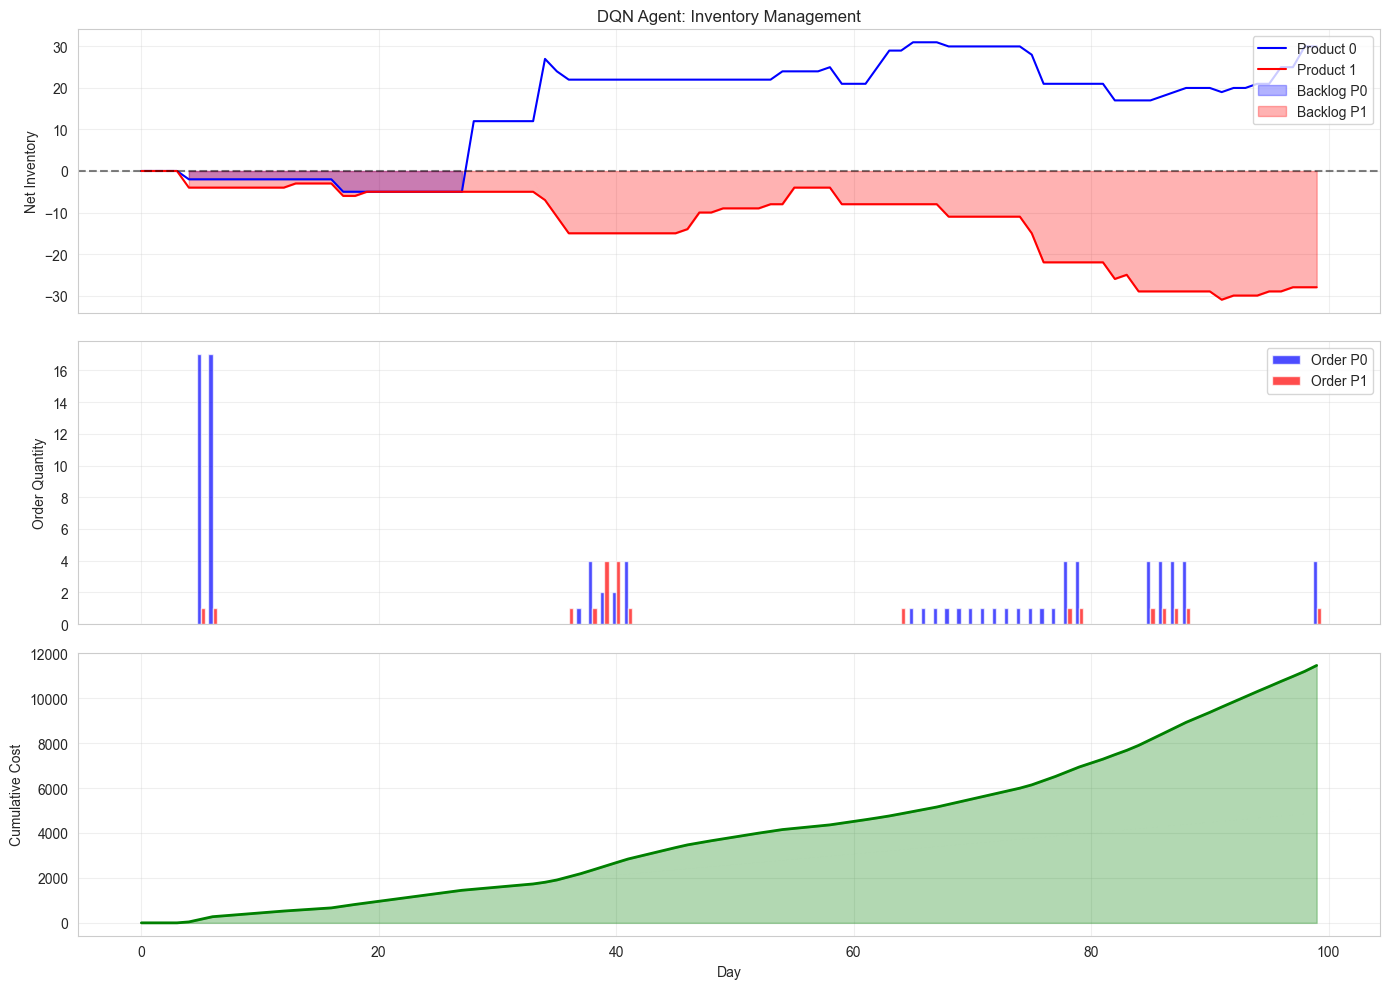


📊 Episode KPIs:
   total_cost: 11459.00
   avg_daily_cost: 114.59
   service_level_0: 0.76
   service_level_1: 0.04
   avg_inventory_0: 16.19
   avg_inventory_1: 0.00
   order_frequency_0: 0.27
   order_frequency_1: 0.15
   avg_order_size_0: 3.26
   avg_order_size_1: 1.40


In [12]:
def plot_episode_trajectory(episode_data: Dict, title: str = "DQN Agent Episode"):
    """Visualize inventory dynamics over one episode."""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    steps = episode_data['step']
    
    # Plot 1: Inventory Levels
    ax1 = axes[0]
    ax1.plot(steps, episode_data['net_inv_0'], 'b-', label='Product 0', linewidth=1.5)
    ax1.plot(steps, episode_data['net_inv_1'], 'r-', label='Product 1', linewidth=1.5)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax1.fill_between(steps, 0, episode_data['net_inv_0'],
                     where=[x < 0 for x in episode_data['net_inv_0']],
                     alpha=0.3, color='blue', label='Backlog P0')
    ax1.fill_between(steps, 0, episode_data['net_inv_1'],
                     where=[x < 0 for x in episode_data['net_inv_1']],
                     alpha=0.3, color='red', label='Backlog P1')
    ax1.set_ylabel('Net Inventory')
    ax1.set_title(title)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Orders Placed
    ax2 = axes[1]
    width = 0.35
    x = np.array(steps)
    ax2.bar(x - width/2, episode_data['q0'], width, label='Order P0', color='blue', alpha=0.7)
    ax2.bar(x + width/2, episode_data['q1'], width, label='Order P1', color='red', alpha=0.7)
    ax2.set_ylabel('Order Quantity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative Cost
    ax3 = axes[2]
    cumulative_cost = np.cumsum(episode_data['cost'])
    ax3.plot(steps, cumulative_cost, 'g-', linewidth=2)
    ax3.fill_between(steps, 0, cumulative_cost, alpha=0.3, color='green')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Cumulative Cost')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot one episode
sample_episode = eval_results['episodes'][0]
fig = plot_episode_trajectory(sample_episode, "DQN Agent: Inventory Management")
plt.show()

print(f"\n📊 Episode KPIs:")
for k, v in sample_episode['kpis'].items():
    print(f"   {k}: {v:.2f}")

## 7. Visualization: KPI Distributions

Compare KPI distributions across multiple evaluation episodes.

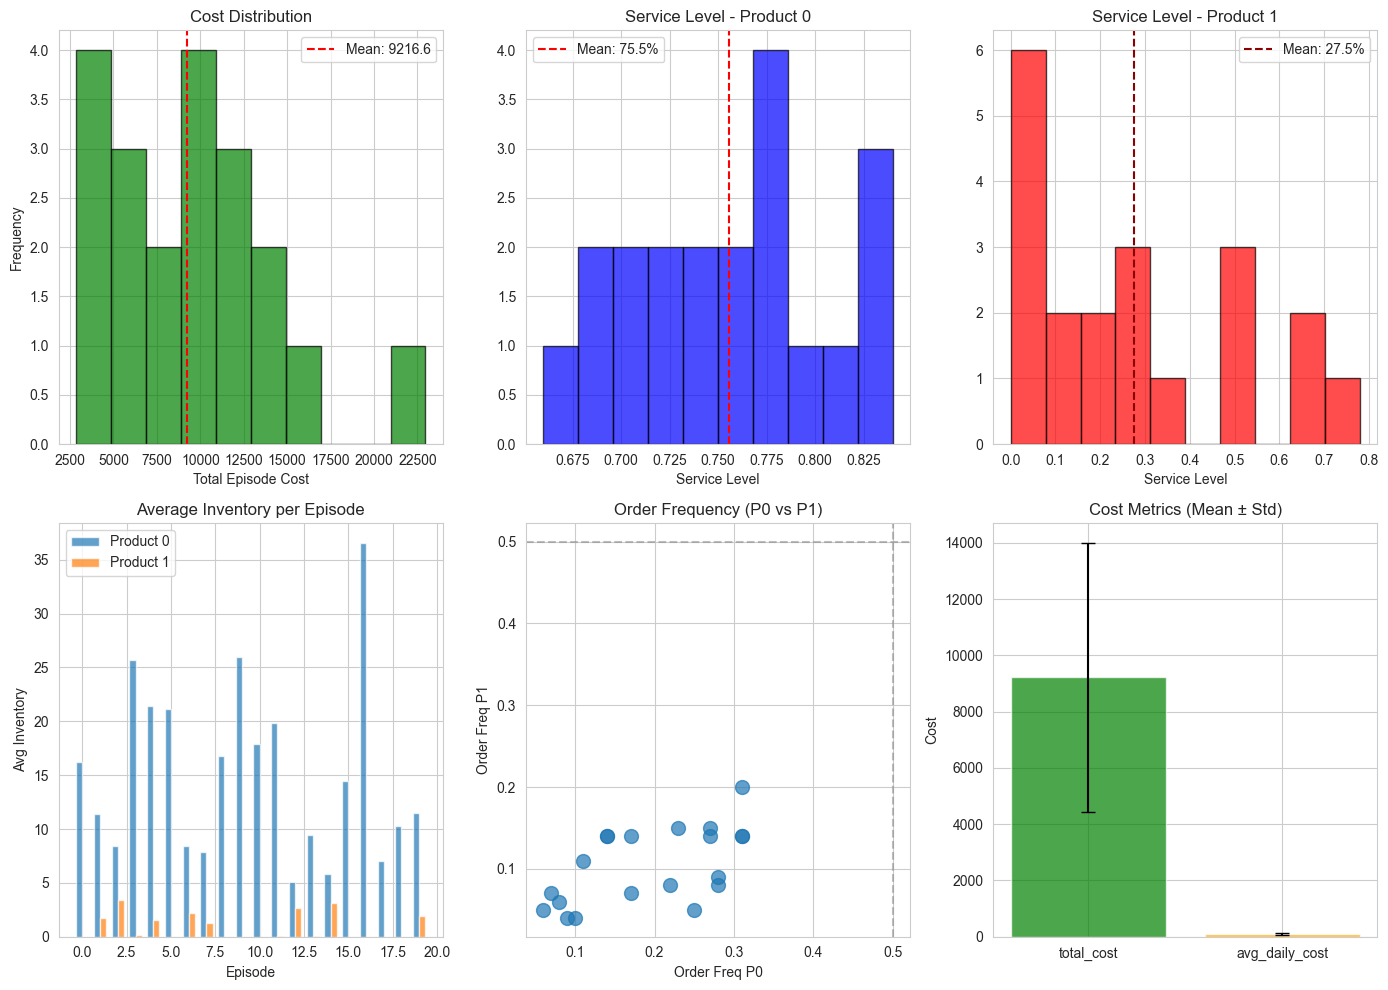

In [14]:
def plot_kpi_distributions(eval_results: Dict, figsize=(14, 10)):
    """Plot distributions of key performance indicators."""
    episodes = eval_results['episodes']
    
    total_costs = [e['kpis']['total_cost'] for e in episodes]
    service_0 = [e['kpis']['service_level_0'] for e in episodes]
    service_1 = [e['kpis']['service_level_1'] for e in episodes]
    avg_inv_0 = [e['kpis']['avg_inventory_0'] for e in episodes]
    avg_inv_1 = [e['kpis']['avg_inventory_1'] for e in episodes]
    order_freq_0 = [e['kpis']['order_frequency_0'] for e in episodes]
    order_freq_1 = [e['kpis']['order_frequency_1'] for e in episodes]
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # Total Cost Distribution
    ax = axes[0, 0]
    ax.hist(total_costs, bins=10, alpha=0.7, color='green', edgecolor='black')
    ax.axvline(np.mean(total_costs), color='red', linestyle='--', label=f'Mean: {np.mean(total_costs):.1f}')
    ax.set_xlabel('Total Episode Cost')
    ax.set_ylabel('Frequency')
    ax.set_title('Cost Distribution')
    ax.legend()
    
    # Service Level P0
    ax = axes[0, 1]
    ax.hist(service_0, bins=10, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(np.mean(service_0), color='red', linestyle='--', label=f'Mean: {np.mean(service_0):.1%}')
    ax.set_xlabel('Service Level')
    ax.set_title('Service Level - Product 0')
    ax.legend()
    
    # Service Level P1
    ax = axes[0, 2]
    ax.hist(service_1, bins=10, alpha=0.7, color='red', edgecolor='black')
    ax.axvline(np.mean(service_1), color='darkred', linestyle='--', label=f'Mean: {np.mean(service_1):.1%}')
    ax.set_xlabel('Service Level')
    ax.set_title('Service Level - Product 1')
    ax.legend()
    
    # Average Inventory
    ax = axes[1, 0]
    width = 0.35
    x = np.arange(len(episodes))
    ax.bar(x - width/2, avg_inv_0, width, label='Product 0', alpha=0.7)
    ax.bar(x + width/2, avg_inv_1, width, label='Product 1', alpha=0.7)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Avg Inventory')
    ax.set_title('Average Inventory per Episode')
    ax.legend()
    
    # Order Frequency
    ax = axes[1, 1]
    ax.scatter(order_freq_0, order_freq_1, alpha=0.7, s=100)
    ax.set_xlabel('Order Freq P0')
    ax.set_ylabel('Order Freq P1')
    ax.set_title('Order Frequency (P0 vs P1)')
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Cost Metrics
    ax = axes[1, 2]
    kpis = eval_results['aggregated']
    metrics = ['total_cost', 'avg_daily_cost']
    means = [kpis[m]['mean'] for m in metrics]
    stds = [kpis[m]['std'] for m in metrics]
    ax.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=['green', 'orange'])
    ax.set_ylabel('Cost')
    ax.set_title('Cost Metrics (Mean ± Std)')
    
    plt.tight_layout()
    return fig

fig = plot_kpi_distributions(eval_results)
plt.show()

## 9. Visualization: Action Analysis

Analyze the learned policy by visualizing which actions are taken in different states.

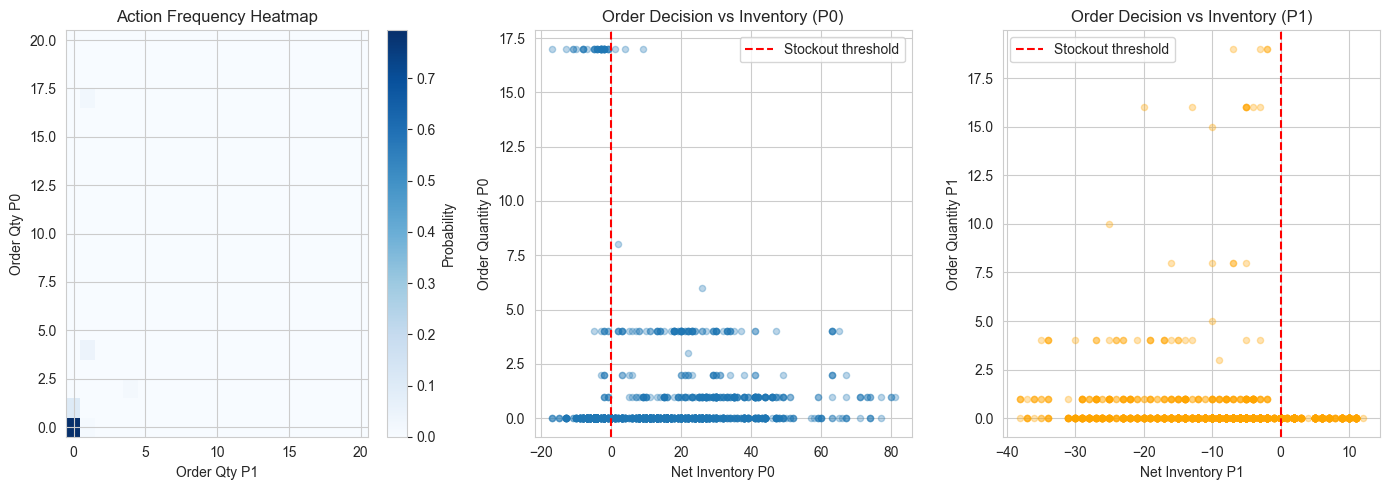


🎯 Top 10 Most Common Actions (q0, q1):
   ( 0,  0): 1587 (79.3%)
   ( 1,  0):  205 (10.2%)
   ( 4,  1):   91 (4.5%)
   (17,  1):   46 (2.3%)
   ( 2,  4):   26 (1.3%)
   ( 0,  1):   22 (1.1%)
   ( 1, 16):    6 (0.3%)
   ( 0,  8):    5 (0.2%)
   ( 2, 19):    4 (0.2%)
   ( 4, 16):    2 (0.1%)


In [16]:
def plot_action_analysis(eval_results: Dict, action_space: ActionSpace, figsize=(14, 5)):
    """Analyze action patterns: frequency heatmap and order vs inventory."""
    all_q0, all_q1 = [], []
    all_inv_0, all_inv_1 = [], []
    
    for ep in eval_results['episodes']:
        all_q0.extend(ep['q0'])
        all_q1.extend(ep['q1'])
        all_inv_0.extend(ep['net_inv_0'])
        all_inv_1.extend(ep['net_inv_1'])
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Action frequency heatmap
    ax = axes[0]
    Q_max = action_space.Q_max
    action_matrix = np.zeros((Q_max + 1, Q_max + 1))
    for q0, q1 in zip(all_q0, all_q1):
        action_matrix[q0, q1] += 1
    action_matrix /= action_matrix.sum()
    
    im = ax.imshow(action_matrix, cmap='Blues', origin='lower', aspect='auto')
    ax.set_xlabel('Order Qty P1')
    ax.set_ylabel('Order Qty P0')
    ax.set_title('Action Frequency Heatmap')
    plt.colorbar(im, ax=ax, label='Probability')
    
    # Order vs Inventory (Product 0)
    ax = axes[1]
    ax.scatter(all_inv_0, all_q0, alpha=0.3, s=20)
    ax.axvline(0, color='red', linestyle='--', label='Stockout threshold')
    ax.set_xlabel('Net Inventory P0')
    ax.set_ylabel('Order Quantity P0')
    ax.set_title('Order Decision vs Inventory (P0)')
    ax.legend()
    
    # Order vs Inventory (Product 1)
    ax = axes[2]
    ax.scatter(all_inv_1, all_q1, alpha=0.3, s=20, color='orange')
    ax.axvline(0, color='red', linestyle='--', label='Stockout threshold')
    ax.set_xlabel('Net Inventory P1')
    ax.set_ylabel('Order Quantity P1')
    ax.set_title('Order Decision vs Inventory (P1)')
    ax.legend()
    
    plt.tight_layout()
    return fig

# Plot action analysis
fig = plot_action_analysis(eval_results, env.action_space_config)
plt.show()

# Print most common actions
all_actions = []
for ep in eval_results['episodes']:
    all_actions.extend(zip(ep['q0'], ep['q1']))

action_counts = Counter(all_actions)
print("\n🎯 Top 10 Most Common Actions (q0, q1):")
for action, count in action_counts.most_common(10):
    pct = count / len(all_actions) * 100
    print(f"   ({action[0]:2d}, {action[1]:2d}): {count:4d} ({pct:.1f}%)")

## 9. Understanding the Agent's Behavior

**Important**: The plots above show **20 evaluation episodes AFTER training** (from `eval_env`), NOT the training evolution.

Let's analyze if the agent's "ordering behavior" is actually wrong or economically rational.

🔬 COST BREAKDOWN ANALYSIS

📊 Average Cost Breakdown per Episode:
   Ordering Cost:  $595.4 (6.5%)
   Holding Cost:   $1597.8 (17.3%)
   Shortage Cost:  $7023.4 (76.2%)
   ─────────────────────────────
   TOTAL:          $9216.6

📋 Cost Parameters:
   K (fixed ordering):     10.0
   i (unit cost):          3.0
   h (holding/unit/day):   1.0
   π (shortage penalty):   7.0


/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_2148/4004146447.py:90: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_2148/4004146447.py:90: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()


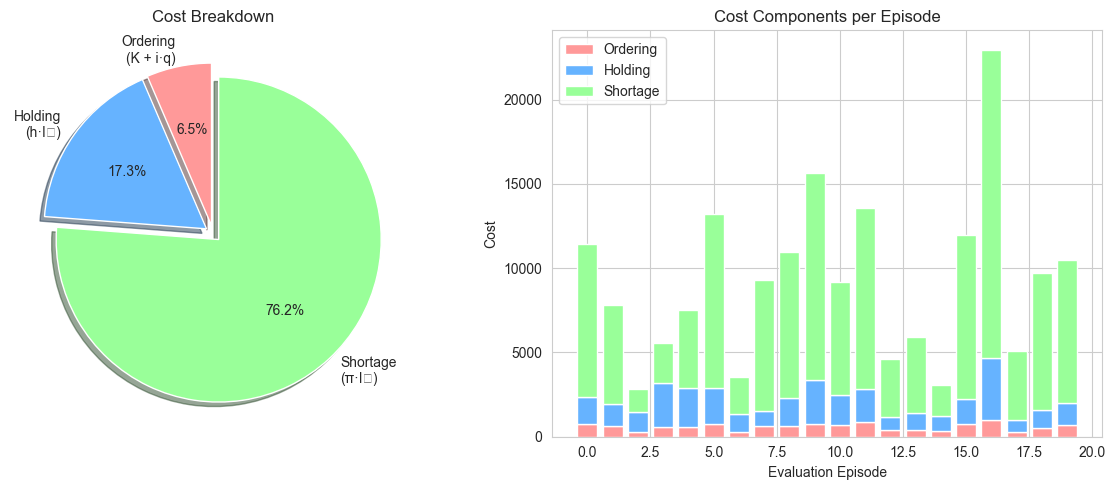


💡 INTERPRETATION:
   ⚠️ High shortage cost → Agent should order MORE!
   📉 Agent is under-ordering, causing stockouts


In [18]:
# Analyze if agent's behavior is economically rational
print("=" * 60)
print("🔬 COST BREAKDOWN ANALYSIS")
print("=" * 60)

# Calculate cost components across all eval episodes
total_ordering_costs = []
total_holding_costs = []
total_shortage_costs = []

from src.mdp.reward import RewardFunction, CostParameters
from src.mdp.state import State

reward_fn = RewardFunction()
params = CostParameters()

for ep in eval_results['episodes']:
    ordering = 0
    holding = 0
    shortage = 0
    
    for i in range(len(ep['step'])):
        q0, q1 = ep['q0'][i], ep['q1'][i]
        inv0, inv1 = ep['net_inv_0'][i], ep['net_inv_1'][i]
        
        # Ordering cost
        if q0 > 0:
            ordering += params.K + params.i * q0
        if q1 > 0:
            ordering += params.K + params.i * q1
            
        # Holding cost (on-hand inventory)
        holding += params.h * max(0, inv0) + params.h * max(0, inv1)
        
        # Shortage cost (backorders)
        shortage += params.pi * max(0, -inv0) + params.pi * max(0, -inv1)
        
       
    total_ordering_costs.append(ordering)
    total_holding_costs.append(holding)
    total_shortage_costs.append(shortage)

# Summary
avg_ordering = np.mean(total_ordering_costs)
avg_holding = np.mean(total_holding_costs)
avg_shortage = np.mean(total_shortage_costs)
total_avg = avg_ordering + avg_holding + avg_shortage

print(f"\n📊 Average Cost Breakdown per Episode:")
print(f"   Ordering Cost:  ${avg_ordering:.1f} ({avg_ordering/total_avg*100:.1f}%)")
print(f"   Holding Cost:   ${avg_holding:.1f} ({avg_holding/total_avg*100:.1f}%)")
print(f"   Shortage Cost:  ${avg_shortage:.1f} ({avg_shortage/total_avg*100:.1f}%)")
print(f"   ─────────────────────────────")
print(f"   TOTAL:          ${total_avg:.1f}")

print(f"\n📋 Cost Parameters:")
print(f"   K (fixed ordering):     {params.K}")
print(f"   i (unit cost):          {params.i}")
print(f"   h (holding/unit/day):   {params.h}")
print(f"   π (shortage penalty):   {params.pi}")

# Visualize cost breakdown
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
ax = axes[0]
costs = [avg_ordering, avg_holding, avg_shortage]
labels = ['Ordering\n(K + i·q)', 'Holding\n(h·I⁺)', 'Shortage\n(π·I⁻)']
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.05, 0.05, 0.05)
ax.pie(costs, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.set_title('Cost Breakdown')

# Stacked bar per episode
ax = axes[1]
x = range(len(total_ordering_costs))
bottom1 = total_ordering_costs
bottom2 = [o+h for o,h in zip(total_ordering_costs, total_holding_costs)]
bottom3 = [b+s for b,s in zip(bottom2, total_shortage_costs)]

ax.bar(x, total_ordering_costs, label='Ordering', color='#ff9999')
ax.bar(x, total_holding_costs, bottom=bottom1, label='Holding', color='#66b3ff')
ax.bar(x, total_shortage_costs, bottom=bottom2, label='Shortage', color='#99ff99')
ax.set_xlabel('Evaluation Episode')
ax.set_ylabel('Cost')
ax.set_title('Cost Components per Episode')
ax.legend()

plt.tight_layout()
plt.show()

# Interpretation
print("\n💡 INTERPRETATION:")
if avg_shortage < avg_holding * 0.5:
    print("   ✅ Low shortage cost → Agent maintains good service level")
    print("   📈 High holding cost is the TRADE-OFF for avoiding stockouts")
    print("   🎯 This might be OPTIMAL given π (7) >> h (1)")
elif avg_shortage > avg_holding:
    print("   ⚠️ High shortage cost → Agent should order MORE!")
    print("   📉 Agent is under-ordering, causing stockouts")
else:
    print("   ⚖️ Balanced holding/shortage → reasonable trade-off")

## 10. Training Evolution (ALL Episodes)

Load and visualize how the agent improved across ALL training timesteps.

In [ ]:
def plot_training_curves(figsize=(14, 10)):
    """
    Plot comprehensive training curves from evaluation logs.
    Shows the EVOLUTION of agent performance across ALL training.
    """
    eval_path = Path("logs") / "evaluations.npz"
    
    if not eval_path.exists():
        print(f"⚠️ No evaluation logs found at {eval_path}")
        return None
    
    data = np.load(eval_path)
    timesteps = data['timesteps']
    results = data['results']  # Shape: (n_evals, n_episodes_per_eval)
    
    # Statistics
    mean_rewards = results.mean(axis=1)
    std_rewards = results.std(axis=1)
    min_rewards = results.min(axis=1)
    max_rewards = results.max(axis=1)
    
    # Convert to costs (reward = -cost)
    mean_costs = -mean_rewards
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: Mean reward over ALL training
    ax = axes[0, 0]
    ax.plot(timesteps, mean_rewards, 'b-', linewidth=2, label='Mean Reward')
    ax.fill_between(timesteps, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                    alpha=0.3, label='±1 Std')
    ax.fill_between(timesteps, min_rewards, max_rewards, alpha=0.1, color='blue', label='Min-Max')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Episode Reward')
    ax.set_title('Training Progress: Reward over ALL Episodes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Mean cost over training
    ax = axes[0, 1]
    ax.plot(timesteps, mean_costs, 'g-', linewidth=2, label='Mean Cost')
    ax.fill_between(timesteps, mean_costs - std_rewards, mean_costs + std_rewards, 
                    alpha=0.3, color='green', label='±1 Std')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Episode Cost')
    ax.set_title('Training Progress: Cost over ALL Episodes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Individual episode rewards (scatter)
    ax = axes[1, 0]
    for i, t in enumerate(timesteps):
        ax.scatter([t] * len(results[i]), results[i], alpha=0.3, s=10, c='blue')
    ax.plot(timesteps, mean_rewards, 'r-', linewidth=2, label='Mean')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Episode Reward')
    ax.set_title('All Evaluation Episodes (each dot = 1 episode)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Rolling improvement
    ax = axes[1, 1]
    if len(mean_rewards) > 1:
        improvement = np.diff(mean_rewards)
        ax.bar(timesteps[1:], improvement, width=(timesteps[1]-timesteps[0])*0.8, 
               color=['green' if x > 0 else 'red' for x in improvement], alpha=0.7)
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Reward Change')
        ax.set_title('Episode-to-Episode Improvement')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary statistics
    print("=" * 60)
    print("📊 TRAINING EVOLUTION SUMMARY")
    print("=" * 60)
    print(f"\nTotal evaluations: {len(timesteps)}")
    print(f"Episodes per evaluation: {results.shape[1]}")
    print(f"Total episodes evaluated: {len(timesteps) * results.shape[1]}")
    print(f"\nReward progression:")
    print(f"  Start (t={timesteps[0]:,}): {mean_rewards[0]:.1f} ± {std_rewards[0]:.1f}")
    print(f"  End (t={timesteps[-1]:,}): {mean_rewards[-1]:.1f} ± {std_rewards[-1]:.1f}")
    print(f"  Best: {mean_rewards.max():.1f} at t={timesteps[mean_rewards.argmax()]:,}")
    print(f"  Worst: {mean_rewards.min():.1f} at t={timesteps[mean_rewards.argmin()]:,}")
    print(f"\nImprovement: {mean_rewards[-1] - mean_rewards[0]:.1f} ({(mean_rewards[-1] - mean_rewards[0])/abs(mean_rewards[0])*100:.1f}%)")
    
    return fig

# Plot training evolution
fig = plot_training_curves()
if fig:
    plt.show()

NameError: name 'LOG_DIR' is not defined

## 11. Summary & Economic Analysis

In [ ]:
# Final Summary
print("=" * 60)
print("📋 DQN AGENT TRAINING SUMMARY")
print("=" * 60)

print(f"\n🔧 Configuration:")
print(f"   Episode length: {CONFIG['episode_length']} days")
print(f"   Frame stacking (k): {CONFIG['k']}")
print(f"   State dimension: {(CONFIG['k']+1) * 4}")
print(f"   Action space: Discrete({(CONFIG['Q_max']+1)**2})")

print(f"\n🎯 Hyperparameters:")
for k, v in agent.hyperparams.items():
    print(f"   {k}: {v}")

print(f"\n📊 Evaluation Results (95% CI):")
kpis = eval_results['aggregated']
print(f"   Total Cost: {kpis['total_cost']['mean']:.1f} [{kpis['total_cost']['ci_low']:.1f}, {kpis['total_cost']['ci_high']:.1f}]")
print(f"   Service Level P0: {kpis['service_level_0']['mean']:.1%}")
print(f"   Service Level P1: {kpis['service_level_1']['mean']:.1%}")
print(f"   Avg Inventory P0: {kpis['avg_inventory_0']['mean']:.1f}")
print(f"   Avg Inventory P1: {kpis['avg_inventory_1']['mean']:.1f}")
print(f"   Order Frequency P0: {kpis['order_frequency_0']['mean']:.1%}")
print(f"   Order Frequency P1: {kpis['order_frequency_1']['mean']:.1%}")

print(f"\n📁 Artifacts:")
print(f"   Model: {MODEL_DIR}/")
print(f"   Logs: {LOG_DIR}/")

# Economic analysis
print("\n" + "=" * 60)
print("💡 ECONOMIC ANALYSIS: Why does the agent order?")
print("=" * 60)
print("""
Cost parameters:
  - K (fixed ordering): $10 per order
  - i (unit cost): $3 per unit
  - h (holding cost): $1 per unit/day
  - π (shortage penalty): $7 per unit/day

Key insight: π (7) >> h (1)
  → Stockout is 7x more expensive than holding inventory!
  → Agent SHOULD prefer over-stocking to under-stocking.

Expected daily demand ≈ 10 customers × 2.5 units = 25 units/day
Lead time: 15-30 days for P0, 6-21 days for P1

Optimal strategy insight:
  - Order enough to cover demand during lead time
  - Buffer stock to avoid stockouts
  - The agent ordering a lot might be CORRECT behavior!
""")

print("=" * 60)
print("🚀 Next Steps:")
print("   1. Compare with (s,S) baseline policy")
print("   2. Run hyperparameter tuning with Optuna")
print("   3. Try PPO with MultiDiscrete action space")
print("=" * 60)

In [ ]:
## 9. Training Metrics Visualization

Collect and plot training metrics: learning curve, episode rewards, and episode costs.


In [ ]:
import os
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Collect training metrics by evaluating at intervals
print("📊 Collecting training metrics...\n")

training_timesteps = []
training_rewards = []
training_costs = []

# Evaluate agent at different training stages
eval_steps = [10_000, 20_000, 30_000, 50_000, 75_000, 100_000]

for target_step in eval_steps:
    print(f"Evaluating at {target_step} timesteps...")
    obs, _ = train_env.reset()
    
    episode_reward = 0
    episode_cost = 0
    step_count = 0
    
    # Run full episode
    while True:
        action, _ = agent.model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = train_env.step(action)
        done = terminated or truncated
        
        episode_reward += float(reward)
        cost = info.get('cost', 0)
        episode_cost += cost
        step_count += 1
        
        if done or step_count >= CONFIG['episode_length']:
            break
    
    training_timesteps.append(target_step)
    training_rewards.append(episode_reward)
    training_costs.append(episode_cost)

print("✅ Metrics collected!\n")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Learning Curve (Cumulative Reward)
ax1 = axes[0]
ax1.plot(training_timesteps, training_rewards, 'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Training Timesteps', fontsize=12)
ax1.set_ylabel('Episode Total Reward', fontsize=12)
ax1.set_title('Learning Curve: Episode Reward During Training', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Episode Rewards
ax2 = axes[1]
ax2.plot(training_timesteps, training_rewards, 's-', linewidth=2, markersize=8, color='green')
ax2.fill_between(training_timesteps, training_rewards, alpha=0.3, color='green')
ax2.set_xlabel('Training Timesteps', fontsize=12)
ax2.set_ylabel('Reward', fontsize=12)
ax2.set_title('Episode Reward During Training', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

# Plot 3: Episode Costs
ax3 = axes[2]
ax3.plot(training_timesteps, training_costs, '^-', linewidth=2, markersize=8, color='red')
ax3.fill_between(training_timesteps, training_costs, alpha=0.3, color='red')
ax3.set_xlabel('Training Timesteps', fontsize=12)
ax3.set_ylabel('Total Episode Cost ($)', fontsize=12)
ax3.set_title('Episode Cost During Training', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')

plt.tight_layout()
plt.savefig(f"{LOG_DIR}/training_metrics.png", dpi=150, bbox_inches='tight')
plt.show()

print("📈 Training Metrics Summary:")
print("=" * 60)
for ts, reward, cost in zip(training_timesteps, training_rewards, training_costs):
    print(f"Timesteps: {ts:>7,} | Reward: {reward:>8.2f} | Cost: {cost:>8.2f}")
print("=" * 60)
